In [22]:
import os
import sys
parent = os.path.abspath(os.path.join('./', os.pardir))
sys.path.insert(0, parent)
fontPath = os.path.abspath(os.path.join(parent,'UKNumberPlate.ttf'))

from nbp_helper_funs import *
from matplotlib import pyplot as plt

from itertools import product
import random
import string

## Explanation

When the blur is estimated correctly (in this case for the `HR25 ZRC` plate) the results of the RMS Search are much improved. In other cases it makes the results worse, but the confidence score is also poor.

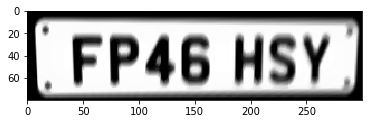

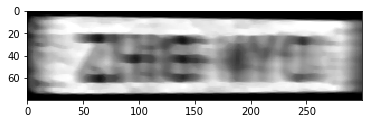

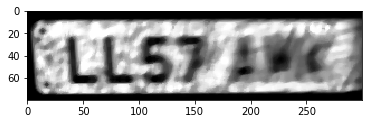

In [50]:
DIR = os.path.join(parent,'hardcoded plates')
im_dirs = list(os.path.join(DIR, file) for file in os.listdir(DIR) if file.endswith('.jpg'))
ims = (openGrayScale(im) for im in im_dirs)
ims = (cropContourImg(im, pad=20) for im in ims)
ims = (straightenImage(im, getCorners(im)) for im in ims)
ims = (im.filter(ImageFilter.MedianFilter(5)) for im in ims)
ims = (ImageOps.autocontrast(im, 2) for im in ims)
ims = list(pil2np(im) for im in ims)

# Show first few plates
for im in ims[:3]:
    plt.imshow(im,cmap='gray')
    plt.show()

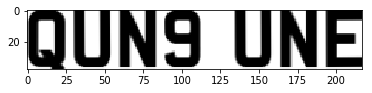

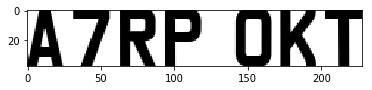

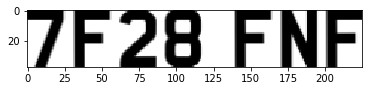

In [37]:
names = list(os.path.split(im)[1] for im in im_dirs[:])
answers = list(name[2:-4].replace('-', ' ') for name in names)

guesses = list(answer for answer in answers)
while len(guesses) < 100:
    guess = randomPlateString()
    if guess not in guesses: guesses.append(guess)
random.shuffle(guesses)

# height of the image (60) * the ratio of the height of the letters to the plate (45/71)
height = int(60*45/71)
gp = lambda plate: pil2np(getPlate(plate, height, fontPath=fontPath))

# show first few guesses
for guess in guesses[:3]:
    plt.imshow(gp(guess),cmap='gray')
    plt.show()

In [38]:
guessPlates = []
guessPlates2 = []

kernel_size = 15 
kernel = makeMotionKernel(kernel_size, True) # Blur by 15 pixels vertically

skip = 3

# Normal plates
for guess in guesses: guessPlates.append(gp(guess))
# Blurred plates
for guess in guesses: guessPlates2.append(convolveImages(gp(guess), kernel=kernel))
    
# Initialise containers
searchResults, searchResults2 = {}, {}
searchResults['scores'] , searchResults['confidence'] , searchResults['answer']  = [], [], []
searchResults2['scores'], searchResults2['confidence'], searchResults2['answer'] = [], [], []

# Loop though the images
for im, answer in zip(ims, answers):
    im = pil2np(im)
    
    # Search though guessPlates
    scores, confidence   = RMSMultiSearch(im, guessPlates, skip=skip, names=guesses)
    searchResults['scores'].append(scores)
    searchResults['confidence'].append(confidence)
    searchResults['answer'].append(answer)
    
    # Search though guessPlates2
    scores2, confidence2   = RMSMultiSearch(im, guessPlates2, skip=skip, names=guesses)
    searchResults2['scores'].append(scores2)
    searchResults2['confidence'].append(confidence2)
    searchResults2['answer'].append(answer)

In [64]:
print('          |     SCORE    CONF.    PLATE       SCORE    CONF.   PLATE        SCORE    CONF.   PLATE')
print('-'*105)
for i,im in enumerate(ims):

    # Unpack containers
    s = searchResults['scores'][i]
    c = searchResults['confidence'][i]*100
    a = searchResults['answer'][i]
    
    s2 = searchResults2['scores'][i]
    c2 = searchResults2['confidence'][i]*100
    a2 = searchResults2['answer'][i]
    
    
    color = bcolors.OKGREEN if a==s[0][1] else bcolors.FAIL
    color2 = bcolors.OKGREEN if a==s2[0][1] else bcolors.FAIL
    line = '{:s}  |  1: {:06.3f}  {:06.3f}  {:s}   2: {:06.3f}  {:06.3f}  {:s}   3: {:06.3f}  {:06.3f}, {:s}'.format(a,s[0][0],c[0],s[0][1],s[1][0],c[1],s[1][1],s[2][0],c[3],s[2][1])
    line = color + line + bcolors.ENDC
    line2 = ' Blurred  |  1: {:06.3f}  {:06.3f}  {:s}   2: {:06.3f}  {:06.3f}  {:s}   3: {:06.3f}  {:06.3f}, {:s}'.format(s2[0][0],c2[0],s2[0][1],s2[1][0],c2[1],s2[1][1],s2[2][0],c2[3],s2[2][1])
    line2 = color2 + line2 + bcolors.ENDC
    print(line)
    print(line2)
    print('-'*105)

          |     SCORE    CONF.    PLATE       SCORE    CONF.   PLATE        SCORE    CONF.   PLATE
---------------------------------------------------------------------------------------------------------
FP46 HSY  |  1: 06.534  10.355  FP46 HSY   2: 05.287  09.693  CF2H 9SV   3: 05.044  05.397, JH45 NBK
 Blurred  |  1: 12.319  04.247  FP46 HSY   2: 05.532  02.245  CF2H 9SV   3: 05.478  02.138, A7RP OKT
---------------------------------------------------------------------------------------------------------
ZH16 WYO  |  1: 05.146  07.120  ZH16 WYO   2: 05.049  07.060  ZO9E BXC   3: 03.674  03.590, FP46 HSY
 Blurred  |  1: 06.086  04.774  62G6 15X   2: 05.836  04.383  QGH2 ESB   3: 05.820  04.268, 93F3 J63
---------------------------------------------------------------------------------------------------------
LL57 AMK  |  1: 05.343  06.303  J6E2 A71   2: 05.142  06.195  LL57 AMK   3: 03.941  04.301, KZY5 OCM
 Blurred  |  1: 09.510  08.745  LL57 AMK   2: 06.171  06.208  62G6 15X   3: 06

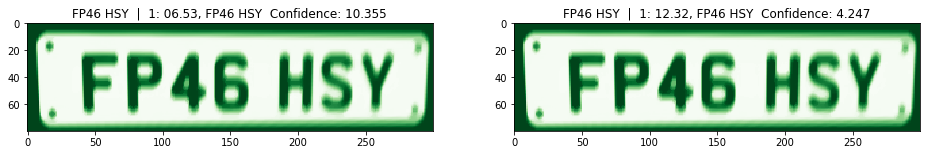

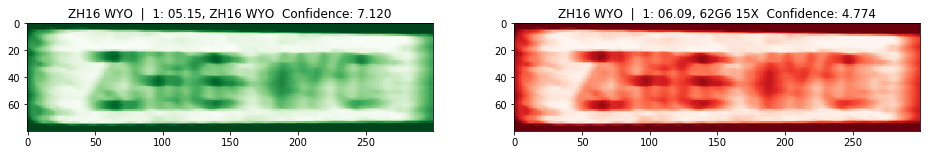

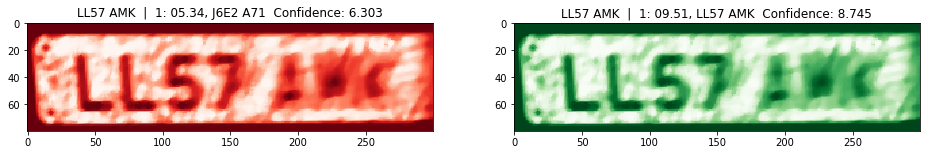

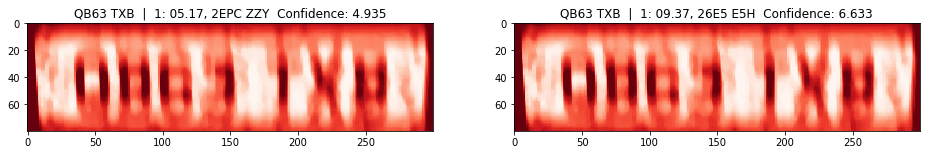

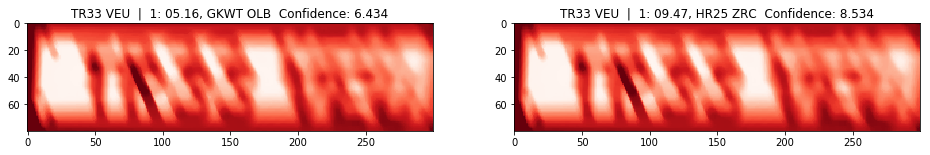

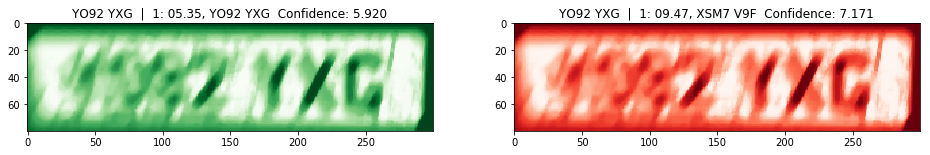

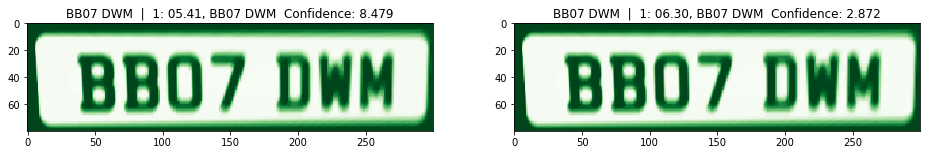

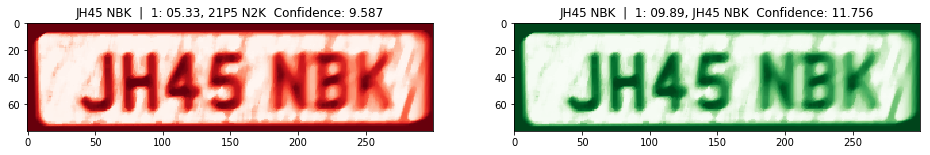

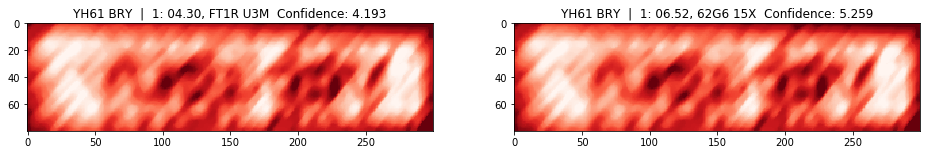

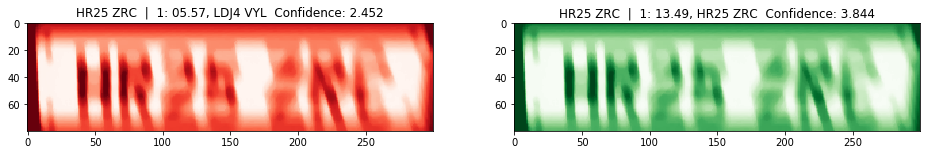

In [67]:
plt.rcParams["figure.figsize"] = (16,5)
for i, im in enumerate(ims):
    # Unpack containers
    s = searchResults['scores'][i]
    c = searchResults['confidence'][i]*100
    a = searchResults['answer'][i]
    
    s2 = searchResults2['scores'][i]
    c2 = searchResults2['confidence'][i]*100
    a2 = searchResults2['answer'][i]
    
    cmap = plt.cm.Greens_r if a==s[0][1] else plt.cm.Reds_r
    cmap2 = plt.cm.Greens_r if a==s2[0][1] else plt.cm.Reds_r
    
    plt.subplot(1,2,1)
    plt.imshow(im, cmap=cmap)
    plt.title('{:s}  |  1: {:05.2f}, {:s}  Confidence: {:1.3f}'.format(a,s[0][0],s[0][1], c[0]))
    plt.subplot(1,2,2)
    plt.imshow(im, cmap=cmap2)
    plt.title('{:s}  |  1: {:05.2f}, {:s}  Confidence: {:1.3f}'.format(a2,s2[0][0],s2[0][1], c2[0]))
    plt.show()